In [1]:
import collections
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy
import os
import pandas

# Import ccp
import sys
sys.path.insert(0, os.path.abspath('../..'))

import ccp.tester.metrics

# Set to true to setup the plots for LaTeX export
latex_export = False

# Set to false to show only theoretical bounds
show_experimental_results = True

if latex_export:
    # For export to LaTeX via PGF
    plt.switch_backend('pgf')
    plt.rc('pgf', texsystem='xelatex')
    plt.rc('pgf', rcfonts=False)
    plt.rc('text', usetex=True)
    
    base_thickness = 1
    document_width_pts = 369.88582
    document_width = document_width_pts / 72.27
    fontsize_small = 8
    fontsize_mid = 10
    fontsize_big = 12
else:
    # For viewing in Jupyter Notebook
    base_thickness = 2
    document_width = 12
    fontsize_small = 15
    fontsize_mid = 17
    fontsize_big = 19

plt.rc('lines', linewidth=base_thickness)
plt.style.use('seaborn-whitegrid')

font = {'family': 'serif', 'serif': 'Linux Libertine O', 'sans-serif': [], 'size': fontsize_small}
plt.rc('font', **font)
plt.rc('axes', titlesize=fontsize_small, labelsize=fontsize_mid)
plt.rc('xtick', labelsize=fontsize_small)
plt.rc('ytick', labelsize=fontsize_small)
plt.rc('legend', fontsize=fontsize_small)
plt.rc('figure', titlesize=fontsize_big)

## Read experiment data

In [2]:
exp_id = '2020-06-08T12:00'
exp_basedir = os.path.join(os.getcwd(), 'out', exp_id)
log_extension = '.log.jsonl'

data = []
te = 5

for path in os.listdir(exp_basedir):
    if path.endswith('.log.jsonl'):
        with open(os.path.join(exp_basedir, path), 'r') as file:
            name = path[:-len(log_extension)]
            metrics = ccp.tester.metrics.measure(file)

            _, tp, mode, _, kp = name.split('-')

            for response in metrics['response']:
                data.append({
                    'tp': int(tp),
                    'mode': mode,
                    'kp': kp,
                    'response': int(response),
                })

data = pandas.DataFrame(data)

## Plot results

### MAPE-K

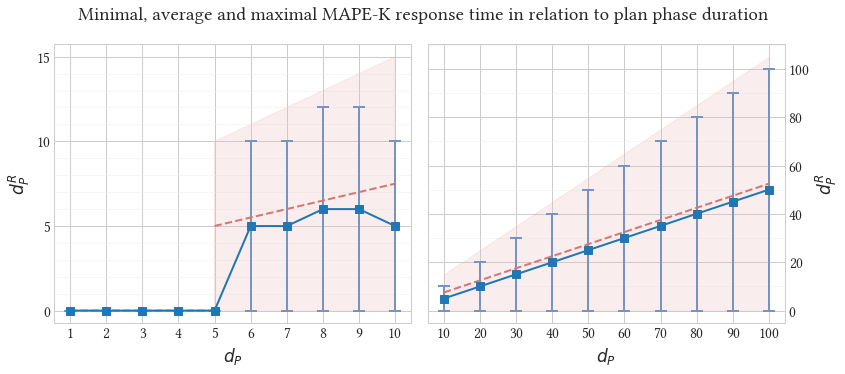

In [3]:
# One plot for values of dᴘ ⩽ 10, one for values above
fig, (ax_lower, ax_upper) = plt.subplots(
    figsize=(document_width, document_width / 2.25),
    nrows=1,
    ncols=2
)

# Fetch data from the Pandas frame
mape_data = data.loc[data['mode'] == 'mape']

data_lower = mape_data.loc[mape_data['tp'] <= 10]
group_lower = data_lower.groupby('tp')

data_upper = mape_data.loc[mape_data['tp'] >= 10]
group_upper = data_upper.groupby('tp')

for group, ax, x_bounds in ((group_lower, ax_lower, numpy.arange(1.0, 10.01, 0.01)),
                            (group_upper, ax_upper, numpy.arange(10.0, 100.1, 0.1))):
    mean = group.mean()['response']
    
    # Compute theoretical bounds
    y_max = numpy.zeros_like(x_bounds)
    y_max[x_bounds + te > 10] = x_bounds[x_bounds + te > 10] + te
    
    y_mean = numpy.zeros_like(x_bounds)
    y_mean[x_bounds + te > 10] = (x_bounds[x_bounds + te > 10] + te) / 2
    
    # Insert NaN values at discontinuities
    pos = numpy.where(numpy.abs(numpy.diff(y_mean)) >= 5)[0] + 1
    x_bounds = numpy.insert(x_bounds, pos, numpy.nan)
    y_mean = numpy.insert(y_mean, pos, numpy.nan)
    y_max = numpy.insert(y_max, pos, numpy.nan)
    
    # Plot theoretical bounds
    ax.fill_between(x_bounds, y_max, color='#ECBAB840')
    ax.plot(x_bounds, y_mean, color='#D47774', linestyle='dashed')
    
    if show_experimental_results:
        # Use error bars to show experimental minima and maxima
        err = [[
            mean - group.min()['response'],
            group.max()['response'] - mean
        ]]

        # Plot data from experiment
        mean.plot(
            ax=ax,
            marker='s',
            yerr=err,
            ecolor='#7693C2',
            markersize=4 * base_thickness,
            capsize=3 * base_thickness,
            capthick=base_thickness,
        )
        
        ax.legend().set_visible(False)

    ax.set_xlabel('$d_P$')
    ax.set_ylabel('$d_P^R$')
    ax.xaxis.set_major_locator(ticker.FixedLocator(mean.index))
    

ax_lower.grid(True, which='major', linewidth=0.5 * base_thickness)
ax_lower.grid(True, which='minor', color='#eee', linewidth=0.25 * base_thickness)
ax_lower.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax_lower.yaxis.set_minor_locator(ticker.MultipleLocator(1))

ax_upper.grid(True, which='major', linewidth=0.5 * base_thickness)
ax_upper.grid(True, which='minor', color='#eee', linewidth=0.25 * base_thickness)
ax_upper.yaxis.set_label_position('right')
ax_upper.yaxis.tick_right()
ax_upper.yaxis.set_major_locator(ticker.MultipleLocator(20))
ax_upper.yaxis.set_minor_locator(ticker.MultipleLocator(10))

if not latex_export: fig.suptitle('Minimal, average and maximal MAPE-K response time in relation to plan phase duration')
fig.tight_layout(rect=[0, 0, 1, 0.925])

if latex_export: plt.savefig('mapek.pgf')

**Observations:**

- When $t_G \leq 10$, $t_P^R = 0$ as expected (events come in slowlier than the time they need to be processed).
- When $t_G \geq 11$, there are some divergences from the theoretical bounds (CCP paper, page 18)
    - The average and max $t_P^R$ seem to fluctuate randomly, especially when $t_G \in \{11, ..., 15\}$.
    - The max of $t_P^R$ should be equal to $t_G$ but is consistently 5 units below that on the right.
    - The average should be equal to $E(t_G)$ according to the theoretical bounds, but here we observe an average of around $\frac{1}{2}E(t_G)$ ($t_G$ is constant, therefore $E(t_G) = t_G$).
    
**Explanations:**

Notice that when $t_G$ and $t_δ$ are not co-prime (i.e. $gcd(t_G, t_δ) > 1$), the shift between change times and loop iteration times does not go through all possible values. Instead, it only goes through multiples of the $gcd$.

For example, if $t_G = 15$ and $t_δ = 10$, $gcd(t_G, t_δ) = 5$ and the observed shifts will only be $\{0, 5, 10\}$. In this case, $max = 10$ and $avg = 5$.
On the contrary, if $t_G = 19$ and $t_δ = 10$, we have $gcd = 1$ and the observed shifts will be all values between 0 and 18 included. In this case, $max = 18$ and $avg = 9$ (closer to what we would expect following the theoretical bounds).

This explains the seemingly-random fluctuations on the left: because $t_G$ goes in increments of $1$, the $gcd$ fluctuates highly. On the right, the $gcd$ is always equal to $5$ because $t_G$ goes by increments of $10$, which explains the more stable-looking graph. It also explains why the max is consistently 5 units below the theoretical value.

Those number-theoretical considerations seem far removed from the problem at hand, which indicates that there is probably a better experimental setup to be found. At the same time, it highlights potential problems in the theoretical bounds from the paper.

### CCP

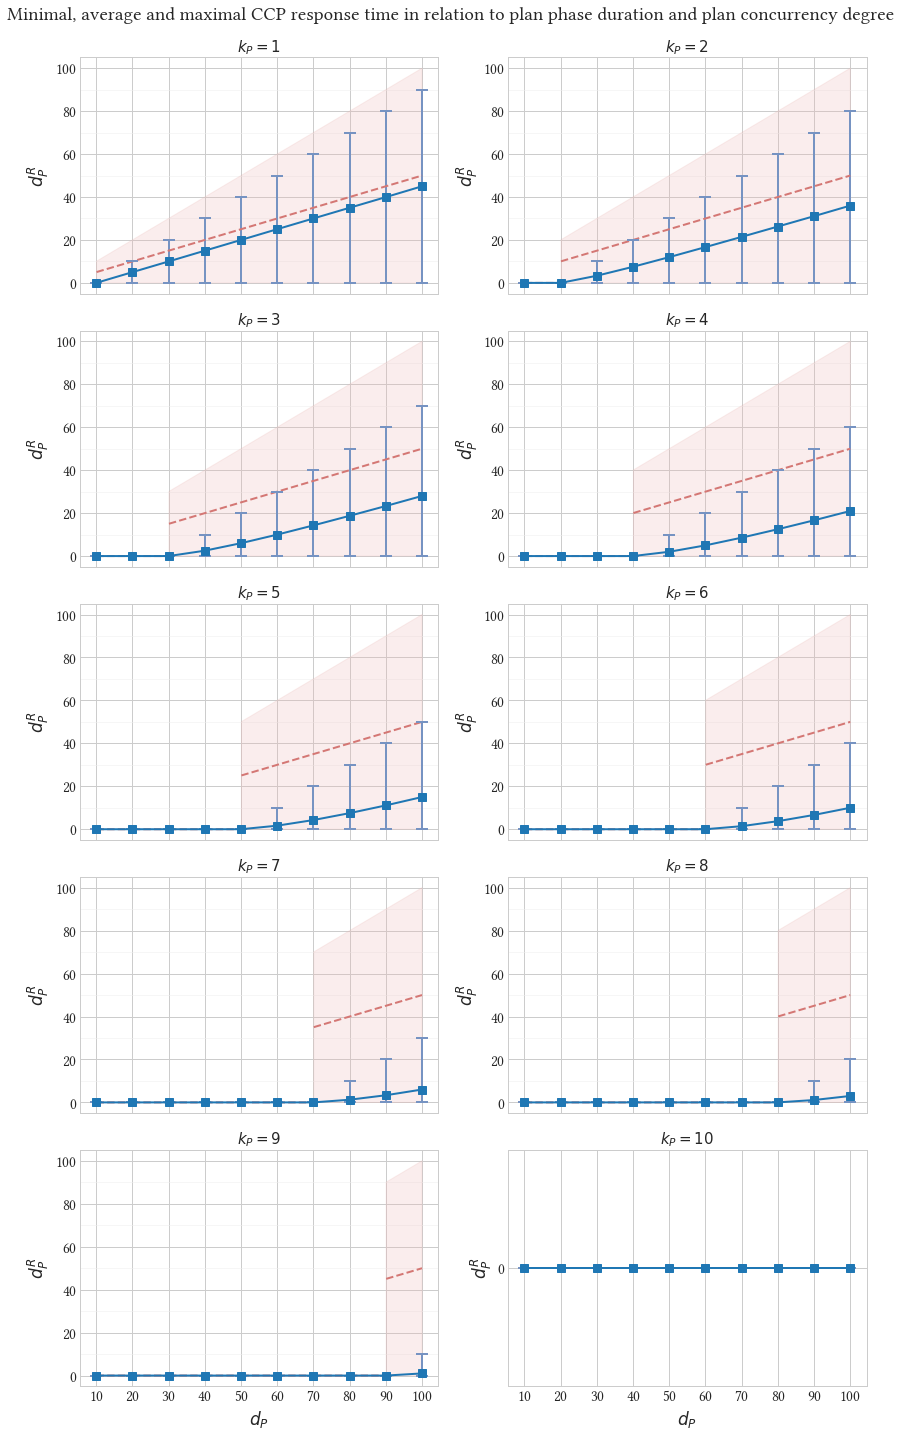

In [4]:
# Set to true to only show two plots, kᴘ = 1 and kᴘ = 5
# (otherwise, all values from 1 to 10 are shown)
compressed = False

if not compressed:
    kp_vals = list(range(1, 11))
    fig, axes = plt.subplots(
        figsize=(document_width, document_width * 1.7),
        nrows=len(kp_vals) // 2,
        ncols=2,
        sharex=True,
    )
else:
    kp_vals = [1, 5]
    fig, axes = plt.subplots(
        figsize=(document_width, document_width / 2.25),
        nrows=1,
        ncols=2
    )
    axes[1].yaxis.set_label_position('right')
    axes[1].yaxis.tick_right()

x_bounds = numpy.arange(10.0, 100.1, 0.1)

for kp, ax in zip(kp_vals, axes.flat):
    ccp_data = data.loc[(data['mode'] == 'ccp') & (data['kp'] == str(kp)) & (data['tp'] >= 10)]
    group = ccp_data.groupby('tp')

    mean = group.mean()['response']
    
    # Compute theoretical bounds
    y_max = numpy.zeros_like(x_bounds)
    y_max[x_bounds / 10 > kp] = x_bounds[x_bounds / 10 > kp]
    
    y_mean = numpy.zeros_like(x_bounds)
    y_mean[x_bounds / 10 > kp] = x_bounds[x_bounds / 10 > kp] / 2
    
    # Insert NaN values at discontinuities
    pos = numpy.where(numpy.abs(numpy.diff(y_mean)) >= 5)[0] + 1
    x_bounds = numpy.insert(x_bounds, pos, numpy.nan)
    y_mean = numpy.insert(y_mean, pos, numpy.nan)
    y_max = numpy.insert(y_max, pos, numpy.nan)
    
    # Plot theoretical bounds
    ax.fill_between(x_bounds, y_max, color='#ECBAB840')
    ax.plot(x_bounds, y_mean, color='#D47774', linestyle='dashed')

    if show_experimental_results:
        err = [[
            mean - group.min()['response'],
            group.max()['response'] - mean
        ]]

        mean.plot(
            ax=ax,
            marker='s',
            yerr=err,
            ecolor='#7693C2',
            markersize=4 * base_thickness,
            capsize=3 * base_thickness,
            capthick=base_thickness,
        )

        ax.legend().set_visible(False)

    ax.set_title(f'$k_P = {kp}$')
    ax.set_xlabel('$d_P$')
    ax.set_ylabel('$d_P^R$')
    
    ax.grid(True, which='major', linewidth=0.5 * base_thickness)
    ax.grid(True, which='minor', color='#eee', linewidth=0.25 * base_thickness)
    
    ax.xaxis.set_major_locator(ticker.FixedLocator(mean.index))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(10))


if not latex_export: fig.suptitle('Minimal, average and maximal CCP response time in relation to plan phase duration and plan concurrency degree')
fig.tight_layout(rect=[-0.01, 0, 1, 0.97])

if latex_export: plt.savefig('ccp.pgf')

**Observations:**

* When $t_P = t_δ = 10$, $t_P^R = 0$ as expected.
* Additionnally, when $t_P / t_δ = t_P / 10 \leq k_P$, $t_P^R = 0$, also as expected.
* In other cases, we can observe some differences:
    - When $k_P > 1$, the max is $10 \times k_P$ lower than expected from the theoretical bounds.
    - The average is also consistently lower than expected (even accounting for the $E(t_P)$ problem). It starts as a straight line and tends towards a curved one as $k_P$ goes up.

## Comparatif

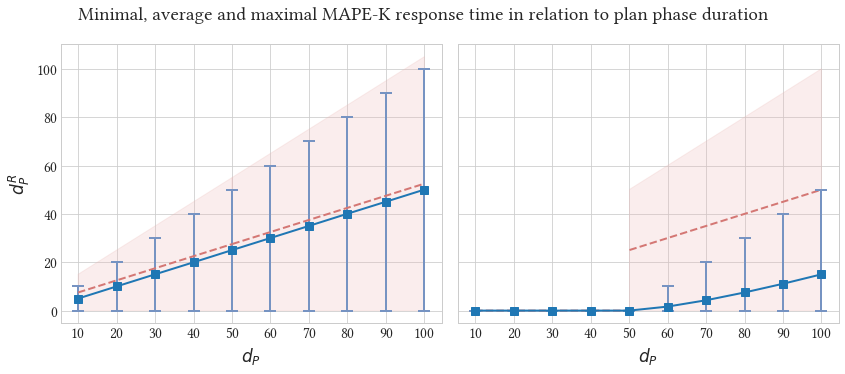

In [5]:
fig, (ax_mape, ax_ccp) = plt.subplots(
    figsize=(document_width, document_width / 2.25),
    nrows=1,
    ncols=2,
    sharey=True
)

kp = 5

mape_data = data.loc[(data['mode'] == 'mape') & (mape_data['tp'] >= 10)]
group_mape = mape_data.groupby('tp')

ccp_data = data.loc[(data['mode'] == 'ccp') & (data['kp'] == str(kp)) & (data['tp'] >= 10)]
group_ccp = ccp_data.groupby('tp')

# Compute theoretical bounds
x_bounds = numpy.arange(10.0, 100.1, 0.1)

mape_y_max = numpy.zeros_like(x_bounds)
mape_y_max[x_bounds + te > 10] = x_bounds[x_bounds + te > 10] + te

mape_y_mean = numpy.zeros_like(x_bounds)
mape_y_mean[x_bounds + te > 10] = (x_bounds[x_bounds + te > 10] + te) / 2

ccp_y_max = numpy.zeros_like(x_bounds)
ccp_y_max[x_bounds / 10 > kp] = x_bounds[x_bounds / 10 > kp]

ccp_y_mean = numpy.zeros_like(x_bounds)
ccp_y_mean[x_bounds / 10 > kp] = x_bounds[x_bounds / 10 > kp] / 2

# Insert NaN values at discontinuities
pos = numpy.where(numpy.abs(numpy.diff(ccp_y_mean)) >= 5)[0] + 1
x_bounds = numpy.insert(x_bounds, pos, numpy.nan)
mape_y_mean = numpy.insert(mape_y_mean, pos, numpy.nan)
mape_y_max = numpy.insert(mape_y_max, pos, numpy.nan)
ccp_y_mean = numpy.insert(ccp_y_mean, pos, numpy.nan)
ccp_y_max = numpy.insert(ccp_y_max, pos, numpy.nan)

for group, ax, y_mean, y_max in ((group_mape, ax_mape, mape_y_mean, mape_y_max),
                                 (group_ccp, ax_ccp, ccp_y_mean, ccp_y_max)):
    mean = group.mean()['response']
    
    ax.fill_between(x_bounds, y_max, color='#ECBAB840')
    ax.plot(x_bounds, y_mean, color='#D47774', linestyle='dashed')
    
    if show_experimental_results:
        err = [[
            mean - group.min()['response'],
            group.max()['response'] - mean
        ]]

        mean.plot(
            ax=ax,
            marker='s',
            yerr=err,
            ecolor='#7693C2',
            markersize=4 * base_thickness,
            capsize=3 * base_thickness,
            capthick=base_thickness,
        )
        
        ax.legend().set_visible(False)

    ax.set_xlabel('$d_P$')
    ax.set_ylabel('$d_P^R$')
    ax.xaxis.set_major_locator(ticker.FixedLocator(mean.index))

ax_lower.grid(True, which='major', linewidth=0.5 * base_thickness)
ax_lower.grid(True, which='minor', color='#eee', linewidth=0.25 * base_thickness)
ax_lower.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax_lower.yaxis.set_minor_locator(ticker.MultipleLocator(1))

ax_upper.grid(True, which='major', linewidth=0.5 * base_thickness)
ax_upper.grid(True, which='minor', color='#eee', linewidth=0.25 * base_thickness)
ax_upper.yaxis.set_label_position('right')
ax_upper.yaxis.tick_right()
ax_upper.yaxis.set_major_locator(ticker.MultipleLocator(20))
ax_upper.yaxis.set_minor_locator(ticker.MultipleLocator(10))

if not latex_export: fig.suptitle('Minimal, average and maximal MAPE-K response time in relation to plan phase duration')
fig.tight_layout(rect=[0, 0, 1, 0.925])

if latex_export: plt.savefig('mapek-vs-ccp.pgf')